# (04) Expectations—0

**Motivation**: Why the mismatch? Finally solved. Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 0
device = f'cuda:{device_idx}'

model_type = 'poisson'

## Load model

In [3]:
tr, meta = load_model(
    model_name='poisson_uniform_c(-3)_rmax(1)_DOVES_z-512_<lin|lin>',
    fit_name='ep3600-b1000-lr(0.005)_beta(1:0x0.5)_temp(0.05:exp-1)_gr(500)_(2024_04_05,08:20)',
    device=device,
    verbose=True,
)

# params: 262.7 K

## Eval

In [4]:
data, loss, rates = tr.validate()

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

{'mse': 137.79117, 'kl': 29.560617, 'kl_diag': 0.057056226, 'tot': 167.35179}

In [5]:
prior_rates = tr.model.log_rates.exp()
prior_rates = to_np(prior_rates.squeeze())
order = np.argsort(prior_rates)
prior_rates = prior_rates[order]

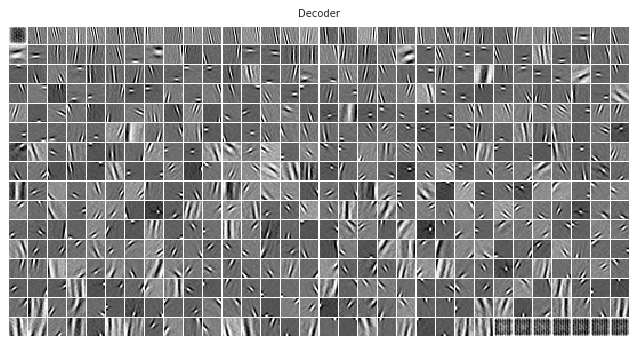

In [6]:
tr.model.show(order=order, dpi=90);

### Good or dead?

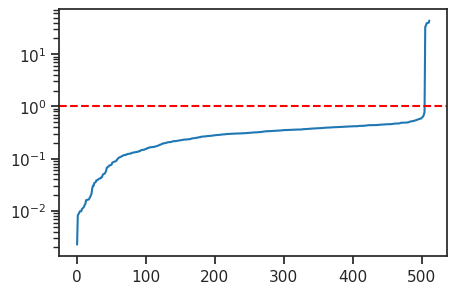

In [7]:
plt.plot(prior_rates)
plt.axhline(1, color='r', ls='--')
plt.yscale('log')
plt.show()

In [8]:
good = prior_rates < 1
good.sum()

505

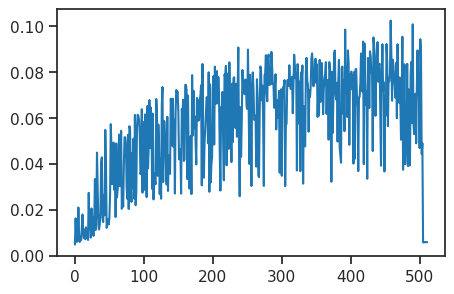

In [9]:
kl_diag = loss['kl_diag'][order]
plt.plot(kl_diag);

In [10]:
kl_diag[-7:].max()

0.005972634

In [11]:
thres = 0.006
dead = kl_diag < thres
dead.sum()

9

In [12]:
set(np.where(dead)[0]).intersection(np.where(~good)[0]), set(np.where(dead)[0]).difference(np.where(~good)[0])

({505, 506, 507, 508, 509, 510, 511}, {0, 7})

In [13]:
phi = to_np(tr.model.fc_dec.weight)
phi = phi[:, order]
a = phi.T @ phi

a.shape

(512, 512)

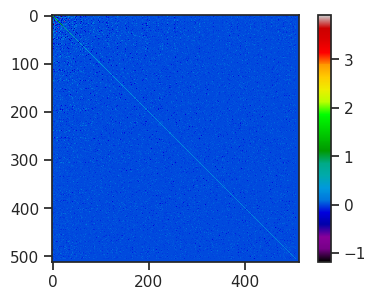

In [14]:
plt.imshow(a, cmap='nipy_spectral')
plt.colorbar()

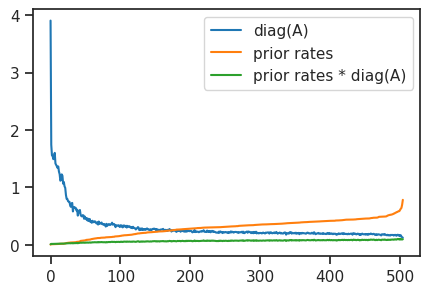

In [15]:
plt.plot(np.diag(a)[good], label='diag(A)')
plt.plot(prior_rates[good], label='prior rates')
plt.plot((prior_rates * np.diag(a))[good], label='prior rates * diag(A)')
plt.legend()
plt.show()

In [16]:
rv = sp_stats.norm(loc=np.log(prior_rates[good]).mean(), scale=np.log(prior_rates[good]).std())
xs = np.linspace(np.log(prior_rates[good]).min() - 0.2, np.log(prior_rates[good]).max() + 0.7, 1000)
pdf = rv.pdf(xs)

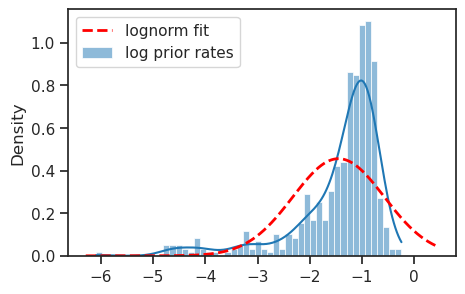

In [17]:
fig, ax = create_figure()

sns.histplot(np.log(prior_rates[good]), stat='density', bins=50, kde=True, label='log prior rates', ax=ax)
ax.plot(xs, pdf, color='r', lw=2, ls='--', label='lognorm fit')
add_legend(ax)
plt.show()

## Closed-form?

### Monte-Carlo estimate

In [18]:
from base.distributions import Poisson

In [19]:
lamb = []
estimate = []
estimate_r = []

for x in tqdm(iter(tr.dl_vld), total=len(tr.dl_vld), ncols=80, disable=False):
    with torch.inference_mode():
        log_dr = tr.model.encode(x)
        log_r = tr.model.log_rates.expand(len(x), -1)
        dist = Poisson(
            log_rates=log_r + log_dr,
            n_exp=300,
            temp=0.0,
        )
        lamb.append(dist.rates)

        mse, mse_r = [], []
        for _ in range(300):
            # torch.poisson()
            spks = dist.sample()
            y = tr.model.decode(spks)
            mse.append(tr.model.loss_recon(y, x))
            # rsample()
            spks = dist.rsample()
            y = tr.model.decode(spks)
            mse_r.append(tr.model.loss_recon(y, x))

        mse = torch.stack(mse).mean(0)
        mse_r = torch.stack(mse_r).mean(0)
        estimate.append(to_np(mse))
        estimate_r.append(to_np(mse_r))

estimate = np.concatenate(estimate)
estimate_r = np.concatenate(estimate_r)
lamb = torch.cat(lamb)

estimate.shape, lamb.shape

100%|███████████████████████████████████████████| 29/29 [01:06<00:00,  2.29s/it]


((28224,), torch.Size([28224, 512]))

### Analytical

In [20]:
x = tr.dl_vld.dataset.x.flatten(1)
phi = tr.model.fc_dec.weight.data
A = phi.T @ phi

x.shape, phi.shape, A.shape

(torch.Size([28224, 256]), torch.Size([256, 512]), torch.Size([512, 512]))

In [21]:
term1 = torch.einsum('si, ij, js -> s', lamb, A, lamb.T)
term2 = torch.einsum('si, ii -> s', lamb, A)
term3 = -2 * torch.einsum('si, ij, js -> s', x, phi, lamb.T)
term4 = torch.einsum('si, is -> s', x, x.T)

loss_final = term1 + term2 + term3 + term4
loss_param = term1 + term2 + term3

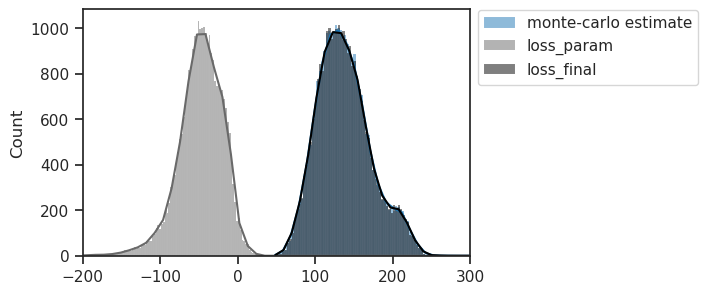

In [22]:
fig, ax = create_figure()

sns.histplot(estimate, color='C0', kde=True, label='monte-carlo estimate')
sns.histplot(to_np(loss_param), color='dimgrey', kde=True, label='loss_param')
sns.histplot(to_np(loss_final), color='k', kde=True, label='loss_final')

ax.set_xlim(-200, 300)
add_legend(ax)
move_legend(ax, (1.0, 1.03))
plt.show()

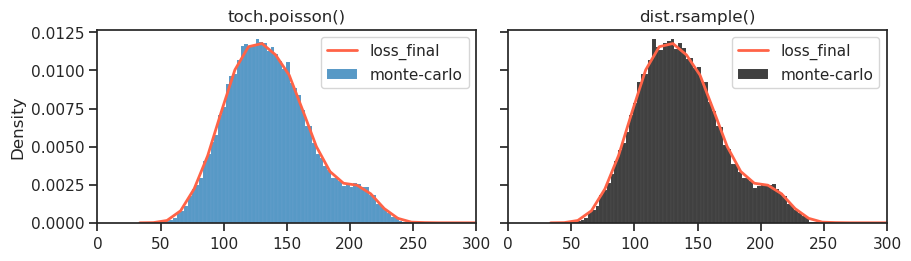

In [23]:
fig, axes = create_figure(1, 2, (9, 2.5), sharey='row', layout='constrained')

sns.histplot(estimate, color='C0', label='monte-carlo', stat='density', ax=axes[0], zorder=1)
sns.histplot(estimate_r, color='k', label='monte-carlo', stat='density', ax=axes[1], zorder=1)

for ax in axes.flat:
    sns.kdeplot(to_np(loss_final), color='tomato', label='loss_final', lw=2, ax=ax, zorder=2)
    ax.set_xlim(0, 300)

axes[0].set_title('toch.poisson()')
axes[1].set_title('dist.rsample()')

add_legend(axes)
plt.show()

In [24]:
sp_stats.pearsonr(estimate, to_np(loss_final))

PearsonRResult(statistic=0.9997846415994122, pvalue=0.0)

In [25]:
sp_stats.pearsonr(estimate_r, to_np(loss_final))

PearsonRResult(statistic=0.9997985943870564, pvalue=0.0)

In [26]:
bad_stim_i = torch.where(loss_final == loss_final.max())[0].item()
bad_stim_i

21609

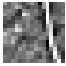

In [27]:
fig, ax = create_figure(dpi=25)
plt.imshow(to_np(tr.dl_vld.dataset.x[bad_stim_i].squeeze()), cmap='Greys_r')
remove_ticks(ax)
plt.show()

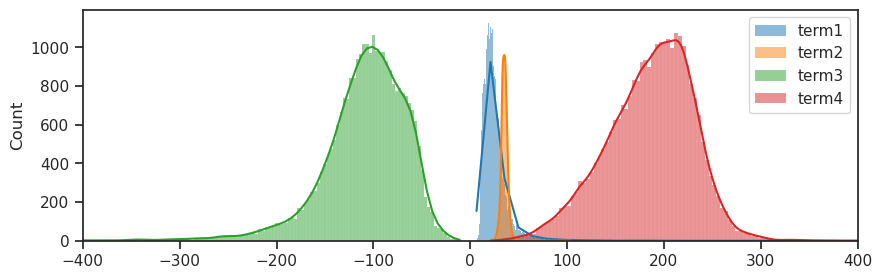

In [28]:
fig, ax = create_figure(1, 1, (10, 3))

sns.histplot(to_np(term1), color='C0', kde=True, label='term1')
sns.histplot(to_np(term2), color='C1', kde=True, label='term2')
sns.histplot(to_np(term3), color='C2', kde=True, label='term3')
sns.histplot(to_np(term4), color='C3', kde=True, label='term4')

ax.set(xlim=(-400, 400))
add_legend(ax)
plt.show()

### Verify ```self.loss_recon_exact()``` implementation

In [29]:
tr.model.update_t(0.0)

In [30]:
estimate = []
for _ in tqdm(range(500), ncols=80):
    _, loss, _ = tr.validate()
    estimate.append(loss['mse'])
estimate = np.stack(estimate).mean(0)
estimate.shape

100%|█████████████████████████████████████████| 500/500 [01:05<00:00,  7.62it/s]


(28224,)

In [31]:
exact = []
for x in iter(tr.dl_vld):
    mse = tr.model.loss_recon_exact(x)
    exact.append(mse)
exact = to_np(torch.concatenate(exact))
exact.shape

(28224,)

In [32]:
sp_stats.pearsonr(estimate, exact)

PearsonRResult(statistic=0.9998834013419294, pvalue=0.0)

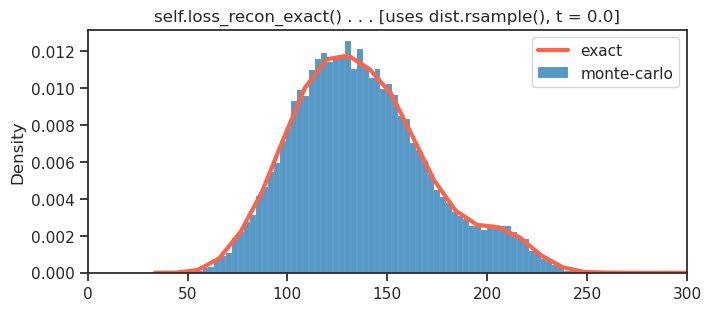

In [33]:
fig, ax = create_figure(1, 1, (7, 3), layout='constrained')

sns.histplot(estimate, color='C0', label='monte-carlo', stat='density', ax=ax, zorder=1)
sns.kdeplot(exact, color='tomato', label='exact', lw=3, ax=ax, zorder=2)

tit = f'self.loss_recon_exact() . . . [uses dist.rsample(), t = {tr.model.temp.item()}]'
ax.set(title=tit, xlim=(0, 300))
add_legend(ax)
plt.show()

In [34]:
exact.mean(), estimate.mean()

(137.7615, 137.75623)

### Now verify for Gaussian

In [35]:
tr, meta = load_model(
    model_name='gaussian_None_DOVES_z-512_<lin|lin>',
    fit_name='ep3600-b1000-lr(0.005)_beta(1:0x0.5)_gr(500)_(2024_04_06,09:03)',
    device=device,
    verbose=True,
)

# params: 394.2 K

In [36]:
tr.model.update_t(1.0)

In [37]:
estimate = []
for _ in tqdm(range(500), ncols=80):
    _, loss, _ = tr.validate()
    estimate.append(loss['mse'])
estimate = np.stack(estimate).mean(0)
estimate.shape

100%|█████████████████████████████████████████| 500/500 [00:48<00:00, 10.31it/s]


(28224,)

In [38]:
exact = []
for x in iter(tr.dl_vld):
    mse = tr.model.loss_recon_exact(x)
    exact.append(mse)
exact = to_np(torch.concatenate(exact))
exact.shape

(28224,)

In [39]:
sp_stats.pearsonr(estimate, exact)

PearsonRResult(statistic=0.9999308566476282, pvalue=0.0)

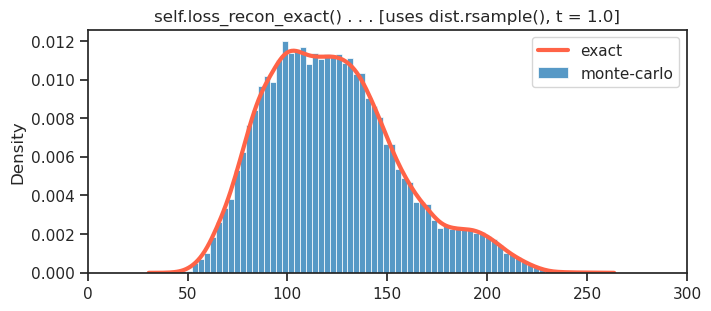

In [40]:
fig, ax = create_figure(1, 1, (7, 3), layout='constrained')

sns.histplot(estimate, color='C0', label='monte-carlo', stat='density', ax=ax, zorder=1)
sns.kdeplot(exact, color='tomato', label='exact', lw=3, ax=ax, zorder=2)

tit = f'self.loss_recon_exact() . . . [uses dist.rsample(), t = {tr.model.temp.item()}]'
ax.set(title=tit, xlim=(0, 300))
add_legend(ax)
plt.show()

In [41]:
exact.mean(), estimate.mean()

(122.71694, 122.7195)

## Check expectations (simulation)

In [42]:
k = 512

w = torch.randn((256, k)) / 20
a = w.T @ w

w.shape, a.shape

(torch.Size([256, 512]), torch.Size([512, 512]))

In [43]:
def fun1(z):
    return (w @ z).squeeze()

def fun2(z):
    return (z.T @ a @ z).squeeze()

In [44]:
from base.distributions import Poisson

lamb = torch.randn((k, 1))
dist = Poisson(lamb * 0.8)

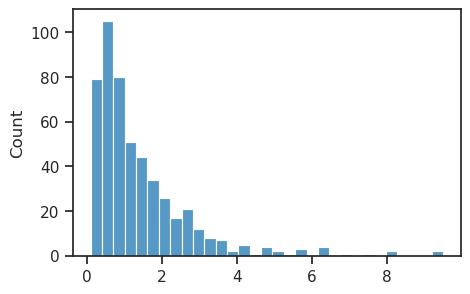

In [45]:
sns.histplot(to_np(dist.rates.squeeze()));

In [46]:
true = fun1(dist.rates)

In [47]:
sampled = []
for _ in range(50000):
    z = dist.sample()
    sampled.append(fun1(z))
sampled = torch.stack(sampled)
sampled.shape

torch.Size([50000, 256])

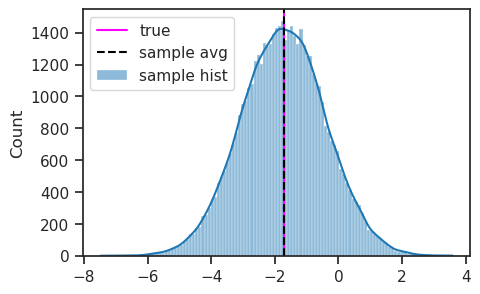

In [48]:
i = 4

ax = sns.histplot(to_np(sampled[:, i]), kde=True, label='sample hist')
ax.axvline(true[i], color='magenta', label='true')
ax.axvline(to_np(sampled[:, i].mean()), color='k', ls='--', label='sample avg')
ax.legend()
plt.show()

In [49]:
true = fun2(dist.rates) + dist.rates.T @ torch.diag(a)

In [50]:
estimates = []
for _ in range(10000):
    z = dist.sample()
    estimates.append(fun2(z))
estimates = torch.stack(estimates)
estimates.shape

torch.Size([10000])

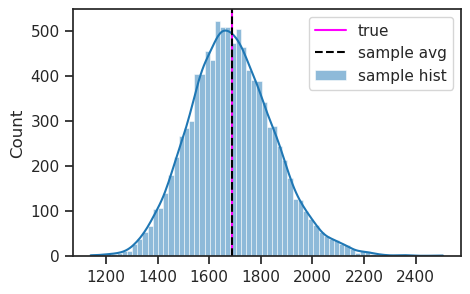

In [51]:
ax = sns.histplot(to_np(estimates), kde=True, label='sample hist')
ax.axvline(true.item(), color='magenta', label='true')
ax.axvline(to_np(estimates.mean()), color='k', ls='--', label='sample avg')
ax.legend()
plt.show()